In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
import os
os.chdir(gitDir)
print(os.listdir("."))


from imgs.report_tools import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['.git', 'README.md', 'data', 'presentations', '.idea', 'training', 'blobs', '.gitignore', '.ipynb_checkpoints', 'imgs', 'report.ipynb']


<center><h1>Multi-Lingual Theme Prediction of Customer Reviews Using Deep Pre-Trained Embeddings</h1></center>
<p align="right">by Michael Sorg (03694850)</p>
<p align="right">Group 6</p>

# Outline

1. Task overview
2. Related Work
3. Package overview
4. Dataset
5. TF-idf classification
6. Deep Learning approach
  - unbalanced training
  - balanced training
  - architecture search
  - train XLING embeddings
7. Organic Dataset
8. Conclusion

9. References
10. Appendix


# 1. Task overview
<a id='task'></a>

1. Train a category prediction model on the Amazon product review dataset based on XLING embeddings per review
2. Evaluate on German without training on German data
3. Fine-tune and evaluate on our Organic Dataset for relevance, entity, and attribute classification (each task independently. Multi-task learning can be integrated as an option)

# 2. Related Work
<a id='related'></a>

For NLP related task pre-computed word embeddings like *Word2Vec* [W2V] or *Glove* [GLOVE] can improve the classification result, especially when using small datasets. Using sentence based embeddings like the *Universal Sentence Encoder* [USE] or [BERT] seem to improve the performance for nlp tasks even further. One disadvantage of the USE is that it supports only one language and therefore is mono-lingual.

For cross-lingual sentence representations *XLING* [XLING] archives state-of-the-art performance and works additionally very well on zero-shot learning tasks.

# 3. Package Overview
<a id='package'></a>
The following table lists the most important files in this repository and briefly explains what the respective file or notebook does.

- **data/Amazon Review.ipynb**
  - Downloads the Amazon Reviews Dataset
  - creating a balanced training set and save it as csv file.
  
- **data/Organic Dataset.ipynb**
  - Downloads the organic dataset
  
- **data/load_dataset.py**
  - parses the dataset csv files and create a tensorflow dataset using the Tensorflow Dataset API [tensorflow dataset api] for efficient data loading and preprocessing


- **train/train.py** 
  - contains the model architecture (tensorflow graph definition) and the main training loop
  - saves  a model checkpoint for each epoch and experiment as well as some training statistics (architecture, used datasets, training time, performance metrics for each epoch, confusion matrix etc.) in a separate folder. This allows different experiments to be evaluated and compared later on.
  
- **train/training.ipynb**
   - high level interface to *train/train.py* for training inside google colab
   - calls the main training file with customizable parameters and plots the result inside the jupyter notebook
   
- **train/organic-fine-tune.ipynb**
   - First trains a model on the amazon dataset and afterwards do fine-tuning on the organic dataset

# 4. Dataset
<a id='dataset'></a>

In this section I describe the used datasets as well as some interesting properties and characteristics of them.

For training the [Amazon Reviews US](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt) dataset was used. This Dataset contains over 130 million reviews from 1995 to 2015. For evaluation and testing the Amazon Multilingual DE dataset was used. It contains around 680.000 reviews from the German marketplace.

The following table shows the amount of reviews for the 35 different categories of the described datasets.

| Category  	|   DE	|  US 	
|:---:	|:---:	|:---:|
|  Video DVD 	| 279068  	|  85982   	
|  Music 	       | 160588  	|  4864250   	
|  Books 	       | 63784  	|  1785998   	
|  Mobile_Apps 	       | 54709  	|  4850361   
|  Digital_Video_Download 	       | 25124  	|  2634782   
|  Digital_Music_Purchase 	       | 21554  	|  2557289   
|  Toys 	       | 18602  	|  705890   
|  Digital_Ebook_Purchase 	       | 12872  	|  2402459   
|  PC 	       | 12250  	|  5069141   
|  Camera 	       | 5421  	|  1801975   
|  Wireless 	       | 4441  	|  960873   
|  Electronics 	       | 4035  	|  2642435   
|  Video 	       | 2927  	|  792114   
|  Sports 	       | 2034  	|  6908555   
|  Video Games 	       | 1706  	|  9002022   
|  Watches 	       | 1575  	|  904766   
|  Shoes 	       | 1517  	|  5331450   
|  Home 	       | 1454  	|  348658  
|  Musical Instruments 	       | 1094  	|  4880467   
|  Baby 	       | 810  	|  1103539   
|  Home Improvement 	       | 672  	|  380605   
|  Home Entertainment 	       | 605  	|  3514943   
|  Office Products 	       | 412  	|  5033377   
|  Personal_Care_Appliances 	       | 411  	|  5101694   
|  Automotive 	       | 410  	|  10319091  
|  Lawn and Garden 	       | 397  	|  4366917   
|  Luggage 	       | 247  	|  4751578   
|  Kitchen 	       | 120  	|  4057148   
|  Furniture 	       | 93  	|  2643620   
|  Health & Personal Care 	       | 37  	|  341932   
|  Software 	       | 19  	|  6221560   
|  Pet Products 	       | 2  	|  5115667  
|  Grocery 	       | 2  	|  3093870   
|  Beauty 	       | 1  	|  1688885   

As we can see in the above table that both datasets are highly imbalanced. Also the distribution of reviews per category is quite different between both datasets. For example the most common category in the German reviews is *Video DVD*. However, this is one of the categories that occurs least frequently in the US reviews.



## Review length

The length of the reviews differs greatly between training and test set. This can be seen in the figure below.

 German            |  English
:-------------------------:|:-------------------------:
![](imgs/histogram_de_cut.png)  |  ![](imgs/histogram_us_cut.png)


In the above histograms I randomly sampled 100.000 reviews from each dataset. We can observe the following things:
* Basically all reviews in the German dataset contain at least 160 characters which is probably some minimum required review length at the German marketplace.
* There are a lot of us reviews which are shorter than 50 characters
* Overall, the German reviews are significantly longer. This can also be seen if we look at the mean and median of the review length:

|   Dataset	|  mean 	|   median	
|:---:	|:---:	|:---	
| US  	|   345	| 169
| DE | 723 | 338

For training I excluded all reviews which are shorter than 20 characters.

## create balanced training set

It has been shown that training on a unbalanced dataset can make the training process difficult and lead to bad classification results [MURP] [imbalanced datasets]. Additionally, due to limited computation resources and the large size of the training dataset I was not able to use all available data for training.
</br>In order to overcome this issues I *created a balanced training dataset by sampling 10.000 random reviews from each category*. Therefore the balanced dataset contains 350.000 reviews in total. For training and validating a very simple and shallow network architecture this takes around 5 hours per epoch. Due to limited resources and time I couldn't use more data for training.

## train-validation-test split
In order to evaluate the developed architecture I created a train-validation-test split. In particular I took 50.000 random us reviews from the training set for validation. Additionally, I took 100.000 random German reviews from the German test set as a second validation set. Thus, we have two validation sets - one for English reviews and one for German.

|   name	|  size 	|   description	
|:---:	|:---:	|:---	
| train  	|   300.000	| balanced, 10k reviews per category
| validation 1 | 50.000 | balanced, english
| validation 2 | 100.000 | unbalanced, german
| test | 580.000 | unbalanced, german test set

## Different languages in the test set


The Amazon Multilingual DE dataset contains reviews from the german amazon marketplace. However, this does not mean that all reviews are in german, because customers are free to write reviews in every language they want. To further analyze this I used the [*langdetect*] library to detect different languages in the german test set. The most common languages can be seen in the following table:

|   Language	|  number of reviews
|:---:	|:---:-	
| DE  	|   628.461	
| EN | 48.660
| FR | 307
| ES | 180
| NL | 179
| CA | 158
| IT | 150
| ... | ...

In the above table we can see that about 7 % of the reviews are in english (50k out of 680k reviews)! <br>
Since my task is it to do zero-shot learning on german I excluded the non-german reviews from the test set. In the appendix I show what happens if we don't filter out other languages. My assumption was that the perfromance goes down if we exclude english reviews from the test set. However,  it didn't change anything - the performance on the test set didn't change. This probably due to the fact that the cross-lingual XLING embeddings work very well.


# 5. TF-IDF based classification
<a id='tf-idf'></a>

*Term Frequency - Inverse Data Frequency (TF-IDF)* is a widely used (non deep-learning based) method in the NLP area. TF-IDF estimates how important a word is within a document by counting word-frequencies.

In order to do classification we need to combine the computed tf-idf features with a classifier. Popular choices are here *Support Vector Machines (SVM) [SVM]* or a *Perceptron* [PERC]. The results of the different classifiers are stated in the table below:

|   classifier	|  validation 1 (en) 	|   validation 2 (de)	
|:---:	|:---:	|:---:	
| TF-IDF + SVM  	|   54 %         	   | 40 %
| TF-IDF + Perceptron | 45 %         | 33 %

> The above table shows the **micro f1** score on the respective test set. If the "f1 score" is reported in the following sections, then the micro-f1 score is meant.

The above classifiers were trained on English reviews only (training set). As we can see the performance drops quite a bit if we test the trained model on unseen German data. This is not very surprising, because the [Tf-idf Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) was fitted only on English words.


# 6. Deep Learning Approach
<a id='dl'></a>

In the previous sections the dataset and the non deep learning tf-idf baseline method were described. Now we'll discuss the results of training a neural network based on XLING embeddings per review. The overall architecture looks like this:
![](imgs/overview.png)

XLING generates an embedding vector with a fixed length of 512 dimensions for each review. For the amazon category prediction task the final layer is a softmax classification with *35 classes*. Now there are two open questions which we want to answer in the following sections:


1.   Which layers (fully connected, relu, dropout) should we put between input and output layer? Which size should the fully connected layers have? 
2.   Do we train also the XLING embeddings or leave those weights unchanged?



## 6.1 unbalanced training
<a id='unbalanced'></a>

For this moment we do not train XLING embeddings and leave these weights fixed.

As stated in the previous sections the original training set is very unbalanced. What happens if we train on this unbalanced data?

For this experiment we train the simplest possible model. This is called the **baseline model** and has no hidden layer. It therefore consists only of the XLING embedding layer and the final softmax classification layer.

> If not stated otherwise I will always report the *micro f1 score*. For simplicity's sake, I call this value just "f1 score".

In the following figure the loss and f1 score are shown. Both seem to look fine and the result is surprisingly good for the simplest possible architecture.

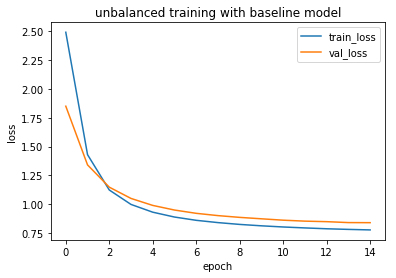

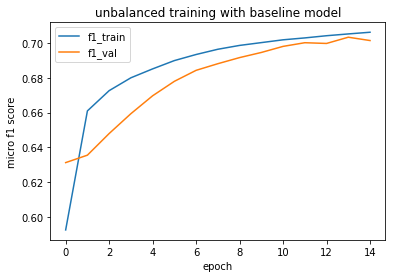

In [0]:
path = "blobs/2019-06-21_unbalanced_usde_100k_baseline/"
title = "unbalanced training with baseline model"
plotLoss(path, title)
plotF1(path, title)

But if we look at the f1 score per class we can see that there is something wrong. We can observe that the model never predicts about half of the classes. Especially classes which occur not very often (small support size) are completely ignored by the model and never predicted during inference time. The model basically only learn to distinguish the most common classes. Since the micro f1 score is ill-defined for classes with no predicted samples these classes are excluded from the overall micro f1 score by sklearn. This is why the f1 score in the above plot reaches about 70 %.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.86      0.71      0.78     40933
           1       0.82      0.93      0.87     23591
           2       0.64      0.49      0.56      9278
           3       0.77      0.93      0.84      8137
           4       0.19      0.45      0.26      3773
           5       0.67      0.00      0.01      3219
           6       0.87      0.54      0.66      2795
           7       0.17      0.65      0.27      1872
           8       0.59      0.59      0.59      1783
           9       0.77      0.69      0.73       767
          10       0.42      0.31      0.36       670
          11       0.43      0.01      0.02       581
          12       0.00      0.00      0.00       435
          13       0.00      0.00      0.00       313
          14       0.58      0.28      0.38       242
          15       0.94      0.81      0.87       240
          16       0.93      0.82      0.87       220
          17       0.00    

<Figure size 432x288 with 0 Axes>

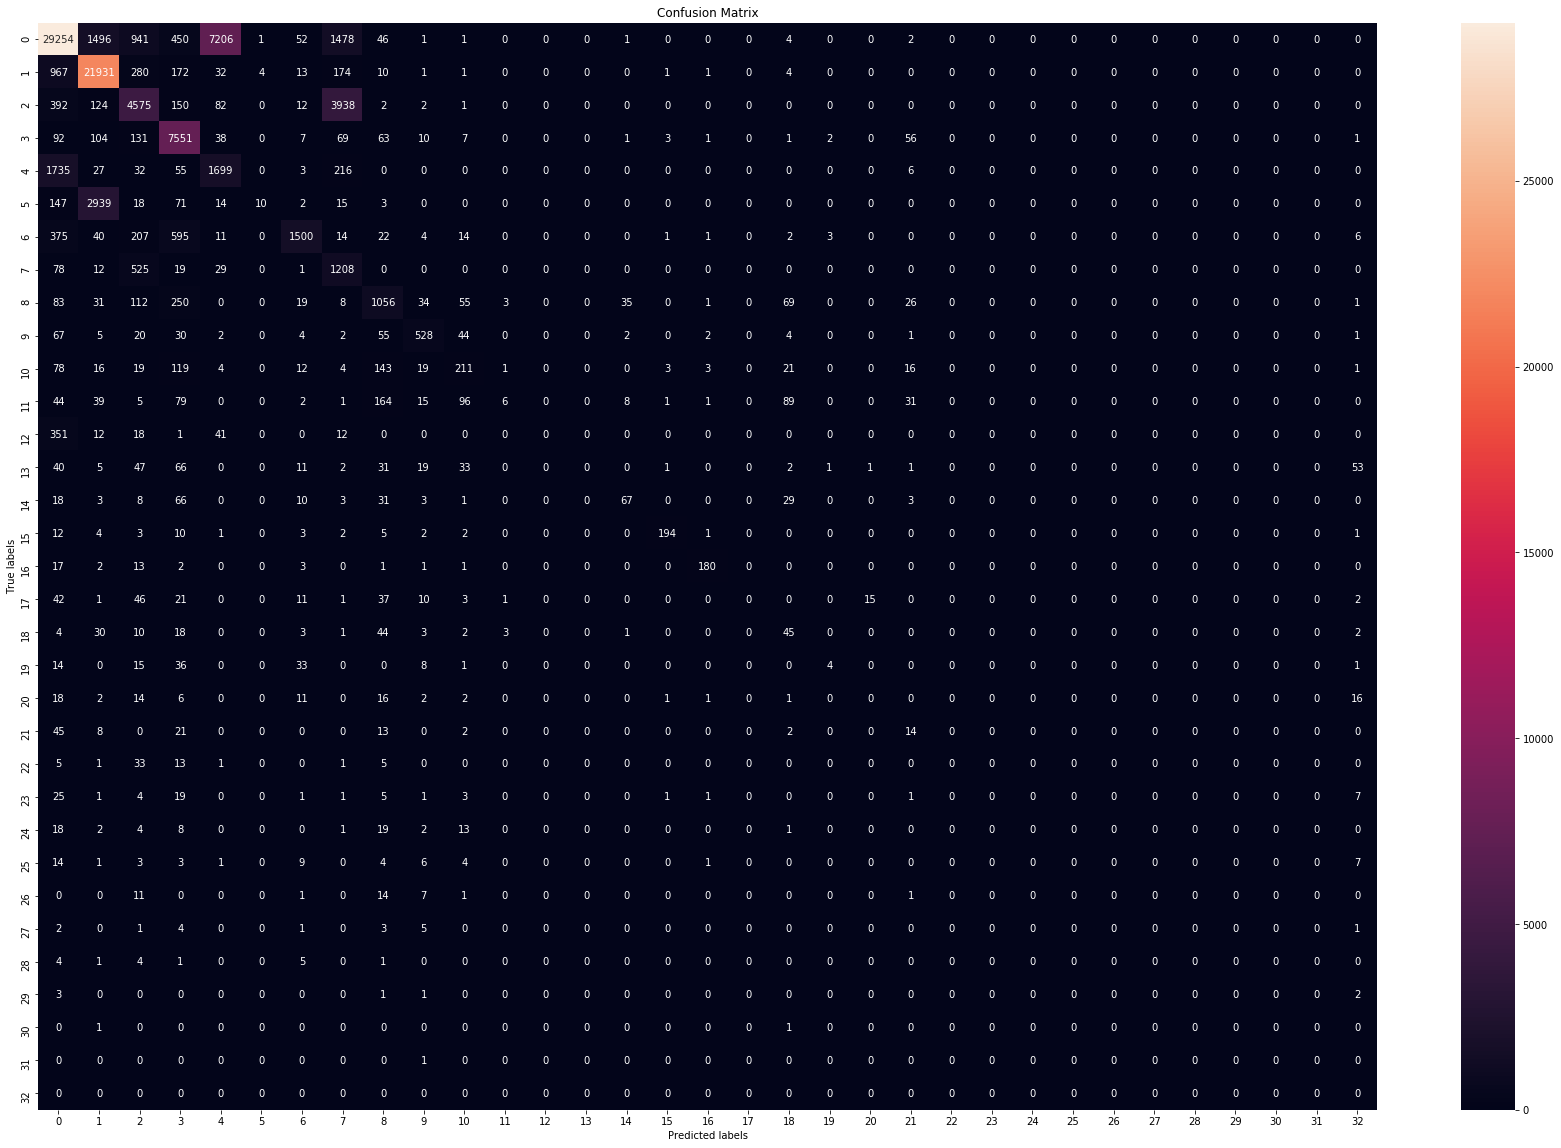

In [0]:
getClassificationReport(path, -1)
plotExperimentCM(path, -1)

The above result is not very surprising. It is known that unbalanced datasets can lead to bad results [imbalanced datasets]. This is why we will no use the created balanced training set described above. 

## 6.2 Balanced training
<a id='balanced'></a>

### Baseline model
<a id='baseline'></a>

As a first baseline we train our simplest possible model on the balanced dataset. The following things can be observed:


* The shape of the loss and f1 score look fine. The maximum of the validation f1 score is around 51 %
* Even the simplest and shallowest model has outperformed our tf-idf baseline.
* It is surprising that the validation loss is lower than the training loss. However, the validation f1 score is slightly below the training f1 score which was expected.
* The model does not learn much after the the third epoch. The learning in the beginning is very steep. Maybe this is due to the fact that the model has very few parameters and can be improved with higher capacity. If we reduce the learning rate (of 0.001) then the curve is not as steep in the beginning, but the final f1 score was also not as high as in the first case.


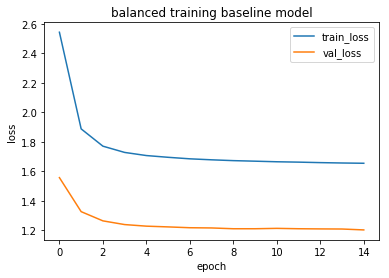

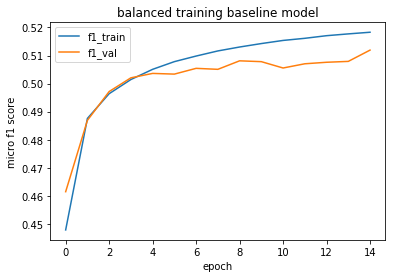

In [0]:
path = "blobs/2019-06-24_balanced_full_baseline/"
title = "balanced training baseline model"
plotLoss(path, title)
plotF1(path, title)

If we look at the f1 scores for each class there are two problems:


1.   The f1 score is for some classes very low or even zero. Especially classes with low support size are badly recognized. 
2.   The f1 score varies extremely between different classes.

Cause of this two problems are often training with a unbalanced dataset. However, here we use a balanced dataset. Why this problems still occur does not open up to me.

In [0]:
getClassificationReport(path, -1)

              precision    recall  f1-score   support

           0       0.91      0.35      0.51    279068
           1       0.85      0.85      0.85    160588
           2       0.73      0.33      0.45     63784
           3       0.93      0.60      0.73     54709
           4       0.19      0.43      0.27     25124
           5       0.32      0.29      0.30     21554
           6       0.74      0.64      0.68     18602
           7       0.16      0.67      0.26     12872
           8       0.60      0.50      0.54     12250
           9       0.59      0.72      0.65      5421
          10       0.39      0.33      0.36      4441
          11       0.28      0.34      0.30      4035
          12       0.02      0.69      0.03      2927
          13       0.16      0.10      0.13      2034
          14       0.07      0.49      0.13      1706
          15       0.51      0.91      0.66      1575
          16       0.68      0.87      0.76      1517
          17       0.02    

## 6.3 Architecture search
<a id='search'></a>

To improve the result of the baseline model and find a good performing architecture a grid search was done. A selection of some tested architectures can be seen in the figure below. 

*The label [False, 150 ,r, d] means for example that we don't train the XLING embeddings and have one hidden layer with 150 units followed by relu and dropout before the final softmax classification layer.*

The plot looks a little bit messy, but we can observe the following things:
*   The blue line is the baseline model described in the previous section.
*   Except from the baseline model the f1 score fluctuates strongly (**zig-zagging**)
*   **Overfitting** happens as soon as we go deeper. Even with just 3-4 layers and a dropout layer after each fully connected layer, overfitting is happening (see for example the pink line with the architecture [False, 250, r, d, 150, r, d, 100, r, d, 50, r, d]). On way to overcome this issue could be to use a reduced learning rate. However, using smaller learning rate resulted either in no learning at all or in a lower f1 score in my experiments.
*  **Overall the architecture [False, 150, "r", "d"] performs best and reaches the highest f1 score of 57 %**. This model uses one hidden layer with 150 units followed by relu and dropout. Training this model took around 5 hours.

For the architecture search I used the training set with a size of 300.000 samples. Does overfitting also happen if we use more training data? To test this I trained some of the deeper models on a balanced training set with around 2 million data points. Surprisingly, this didn't improve the performance - even worse the f1 score decreased (see Appendix). **Using more data does not lead to better performance in my case**.
Theoretically, there is even more data in the amazon reviews dataset available. But due to limited computational resources and time I was not able to use a even bigger dataset than 2 million samples.

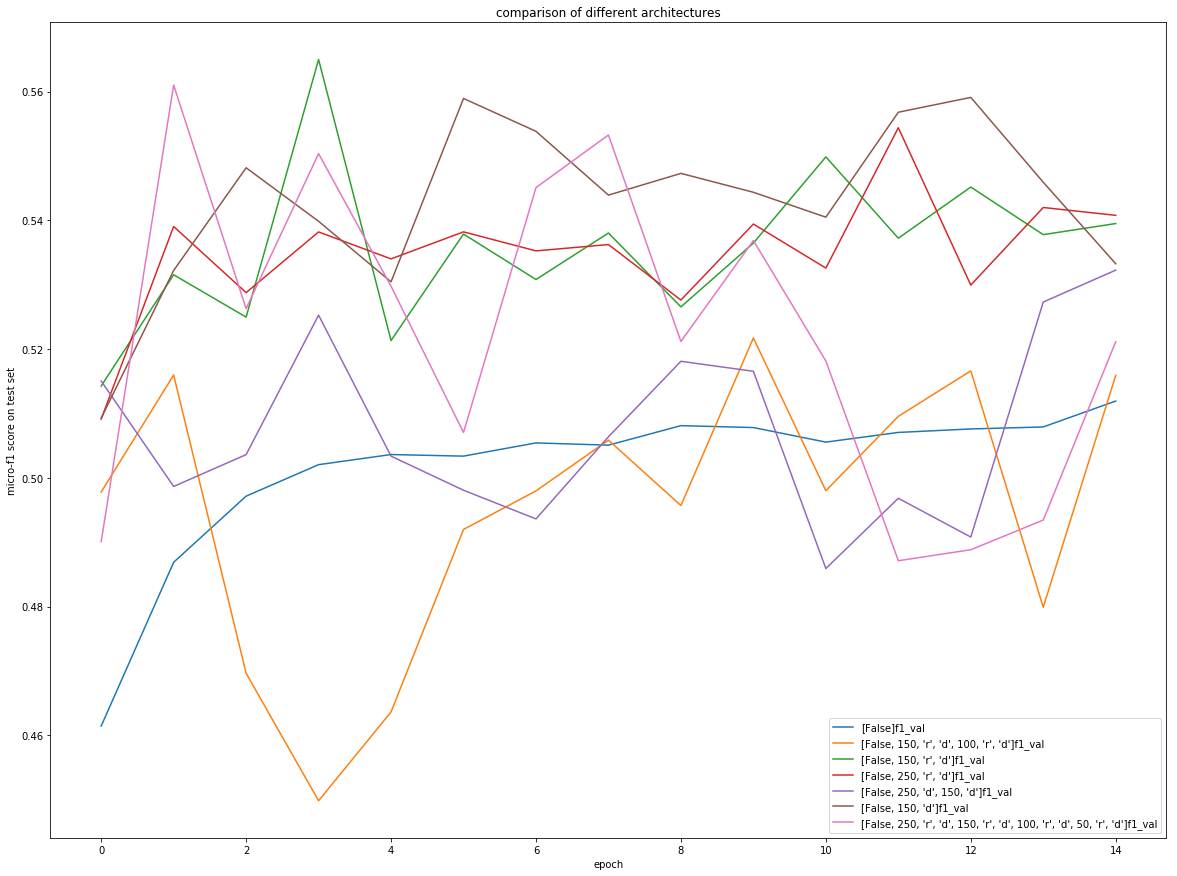

In [0]:
paths = ["blobs/2019-06-24_balanced_full_baseline/","blobs/2019-06-25_balanced_full_search1/","blobs/2019-06-25_balanced_full_search2/","blobs/2019-06-26_balanced_full_search4/",
         "blobs/2019-06-26_balanced_full_search5/","blobs/2019-06-26_balanced_full_search6/","blobs/2019-06-24_deep_balanced_300k_dropout/"]
plt.figure(figsize=(20,15))
for path in paths:
    f = glob.glob(path + "*f1_val.npy")
    x = np.load(f[0])
    plt.plot(x, label=f[0][len(path):-4])
plt.legend()
plt.title("comparison of different architectures")
plt.xlabel("epoch")
plt.ylabel("micro-f1 score on test set")
plt.savefig("compare.png")
plt.show()

Here are some more points which I noticed during the architecture search:

*   Architectures with only fully connected layers work unsurprisingly not as well as architectures with non-linear activations functions between each fully connected layer
*   Relu activation worked best (compared to elu, leaky Relu and tanh)
* The combination of one fully connected layer followed by relu and dropout [DROP] layers worked best
* Introducing batch normalization layers [BN] did not improve the performance. Quite the contrary, it slightly decreases the f1 score.
* Adam Optimizer [ADAM] was the optimizer which worked best (compared to Adadelta [ADAD] and Rmsprop [RMSP]). The best learning rate was 0.001.
* Using L2 regularization had basically no effect. Dropout was a more effective way to prevent overfitting and reducing the generalization gap.

## 6.4 Training XLING embeddings
<a id='xling'></a>

So far we left the XLING weights untouched and didn't train them. Now we'll also include these weights in the optimization process.
For this experiment we'll use again our baseline model - meaning the simplest possible model with the fewest parameters. But this time we train also the XLING weights.

The figure below shows two different models:
1.   The *left column* shows the baseline model with trainable XLING weights **without dropout and regularization and a learning rate of 0.001**. As we can see this model is *strongly overfitting*. The training f1 score almost reaches 100 % after 15 epochs. Also the validation loss is increasing after 4 epochs which is a clear indicator of overfitting.
2.   The *right column* shows a model with a **additonal dropout layer and l2 regularization as well as a learning rate reduced to a tenth of the previous learning rate (0.0001)**. This time the loss looks better, because the validation loss does not start to increase after a few epochs. However, the generalization gap (difference between train and validation f1 score) is quite large.


**We can conclude that also training the XLING embeddings does not work very well. Even with no hidden layer between XLING and the softmax classifiaction layer and with dropout, regularization and a small learning rate the model tends to overfit.**

This is probably due to the fact that *training the XLING embeddings adds around 120 million additional parameters*. In this case I trained the model with 300.000 samples. Therefore we had way more parameter than training data. <br>
Can we overcome this issue by using more training data? To test this I trained the same models with a training set size of 2 million data points. But as described in the previous section **using more data didn't help in this case either**. The models were still overfitting.

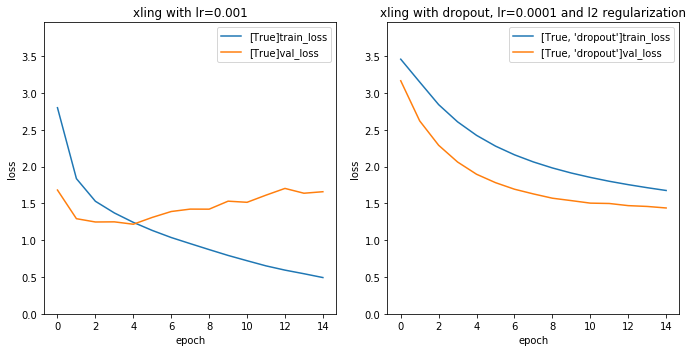

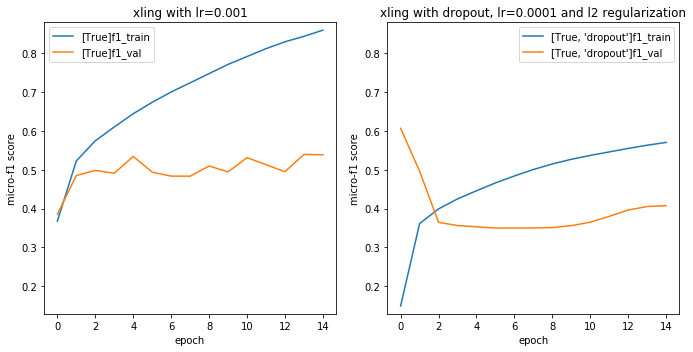

In [2]:
p1 = "blobs/2019-06-24_balanced_300k_xling_baseline/"
p2 = "blobs/2019-06-24_balanced_300k_xling_baseline_dropout_lr_l2reg/"
title1="xling with lr=0.001"
title2="xling with dropout, lr=0.0001 and l2 regularization"
plotExperimentLoss(p1,p2,title1, title2)
plotExperimentf1(p1,p2,title1, title2)

# 7. Organic Dataset
<a id='organic'></a>

For the organic dataset I also did a grid search to find a good architecture for *training a model from scratch*. But here the same problems occurred like in the architecture search above. Due to the fact that the organic dataset is really small (around 4000 samples) overfitting happened here even more quickly. Basically the best architecture was the baseline model (just xling embeddings + softmax). As soon as I added additional hidden layers the performance either didn't improve or the model did overfit.

Can we increase the performance if we do fine-tuning? For this experiment I used the best performing model from the previous task. This model consists of XLING embeddings, a hidden layer with 150 units followed by relu, dropout and softmax classification layers. I reused this model and replaced the final softmax layer with a new one with the respective number of classes for each classification task.
Interestingly, I wasn't able to push the performance by the architecture search. However, **by using fine-tuning on a different dataset the performance increased**, as it can be seen in the following table:

|   Task	|  scratch model 	|   model with fine-tuning	
|:---:	|:---:	|:---:	
| relevance  	|   74 %         	   | 77 %
| entity | 51 %         | 57 %
|attribute | 44 % | 50 %
> The above table show the micro f1 score on the test set.


I didn't have enough time to get deep into the task of *multilabel classification* for the organic dataset. However, first results are listed in the [Appendix](#multilabel). 




# 8. Conclusion

While training a category prediction model based on XLING features per review the following main problems occurred:
1. Even shallow models with 2-3 fully connected layers tend to overfit.
2. Training additionally the XLING embeddings resulted always in overfitting.
3. Increasing the training set size from 300.000 to 2 million did not resolve those problems nor improve the performance.

The final micro f1 scores of the different models are stated in the following table:

|   Task	|  micro f1 on test set 
|:---:	|:---:	
| tf-idf + svm  	                 | 40 %         	  
| baseline model              | 51 %        
| best model                     | 57 % 

<br>
The classification performance on the organic dataset could be improved by using a model which was pre-trained on the amazon reviews dataset.

# 9. References
<a id='references'></a>

## Publications


| Shortcut        | Publication           | 
| :-------------:      |:------------- |
|[ADAM](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) |Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).
|[ADAD](https://arxiv.org/pdf/1212.5701)|Zeiler, Matthew D. "ADADELTA: an adaptive learning rate method." arXiv preprint arXiv:1212.5701 (2012).
|[ATT](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) | Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems. 2017.
|[BERT](https://arxiv.org/pdf/1810.04805.pdf) | Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).
|[BN](https://arxiv.org/pdf/1502.03167.pdf%E7%9A%84paper%E9%80%82%E5%90%88%E6%83%B3%E6%B7%B1%E5%85%A5%E4%BA%86%E8%A7%A3%E5%8E%9F%E7%90%86%EF%BC%8C%E8%BF%99%E4%B8%AA%E8%A7%86%E9%A2%91%E5%BE%88%E6%B8%85%E6%A5%9A%E7%9A%84%E8%AE%B2%E4%BA%86bn%E8%B5%B7%E5%88%B0%E7%9A%84%E4%BD%9C%E7%94%A8%E3%80%82) | Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).
|[DROP](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer) | Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The journal of machine learning research 15.1 (2014): 1929-1958.
|[GLOVE](https://www.aclweb.org/anthology/D14-1162) | Pennington, Jeffrey, Richard Socher, and Christopher Manning. "Glove: Global vectors for word representation." Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP). 2014.
|[ML](http://dml.cs.byu.edu/~cgc/docs/atdm/Readings/MLM-Overview.pdf) | Tsoumakas, Grigorios, and Ioannis Katakis. "Multi-label classification: An overview." International Journal of Data Warehousing and Mining (IJDWM) 3.3 (2007): 1-13.
|[MURP](https://www.researchgate.net/profile/Yi_Murphey/publication/263756556_Neural_Learning_from_Unbalanced_Data_Special_Issue_Engineering_Intelligent_Systems_Guest_Editor_Laszlo_Monostori/links/0912f50d32991d3eed000000.pdf) | Murphey, Yi L., Hong Guo, and Lee A. Feldkamp. "Neural learning from unbalanced data." Applied Intelligence 21.2 (2004): 117-128.
| [PERC](https://link.springer.com/content/pdf/10.1023/A:1007662407062.pdf) | Freund, Yoav, and Robert E. Schapire. "Large margin classification using the perceptron algorithm." Machine learning 37.3 (1999): 277-296.
|[RMSP](https://arxiv.org/pdf/1708.01911) | Kurbiel, Thomas, and Shahrzad Khaleghian. "Training of Deep Neural Networks based on Distance Measures using RMSProp." arXiv preprint arXiv:1708.01911 (2017).
|[SVM](https://lirias.kuleuven.be/retrieve/88556) |Suykens, Johan AK, and Joos Vandewalle. "Least squares support vector machine classifiers." Neural processing letters 9.3 (1999): 293-300.
| [USE](https://arxiv.org/abs/1803.11175)     | Daniel Cer, Yinfei Yang, Sheng-yi Kong, Nan Hua, Nicole Limtiaco, Rhomni St. John, Noah Constant, Mario Guajardo-Céspedes, Steve Yuan, Chris Tar, Yun-Hsuan Sung, Brian Strope, Ray Kurzweil. Universal Sentence Encoder. arXiv:1803.11175, 2018.    
| [W2V](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) | Mikolov, Tomas, et al. "Distributed representations of words and phrases and their compositionality." Advances in neural information processing systems. 2013.
| [XLING](https://arxiv.org/abs/1810.12836)    | M. Chidambaram, Y. Yang, D. Cer, S. Yuan, Y.-H. Sung, B. Strope, and R. Kurzweil. Learning Cross-Lingual Sentence Representations via a Multi-task Dual-Encoder Model. ArXiv e-prints, October 2018.


## Datasets
| Name        | Source           | 
| :-------------:      |:------------- |
|Amazon Reviews US | https://s3.amazonaws.com/amazon-reviews-pds/readme.html <br> https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt
|Amazon Multilingual DE| https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_DE_v1_00.tsv.gz
Organic Dataset | https://syncandshare.lrz.de/dl/fiNDkYy3SNfH6M62mpfPV92c/processed.zip


## Usefull internet ressources

| Topic        | Links           | 
| :-------------      |:------------- |
| sklearn tf-idf classifiaction | https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br>  https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py <br>  http://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XTG-WOgzbIU
| imbalanced datasets| https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ <br> https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
|Google Colab | https://colab.research.google.com/notebooks/io.ipynb
|google cloud instance setup | https://medium.com/andrewmmc-io/setup-vm-instance-on-google-cloud-compute-engine-1e7063cfcde6 <br> https://www.cloudbooklet.com/setting-up-google-cloud-compute-engine-instance/
|google cloud jupyter notebook | https://towardsdatascience.com/running-jupyter-notebook-in-google-cloud-platform-in-15-min-61e16da34d52 <br> https://medium.com/@kn.maragatham09/installing-jupyter-notebook-on-google-cloud-11979e40cd10
|tensorflow dataset api | https://www.tensorflow.org/guide/datasets <br> https://adventuresinmachinelearning.com/tensorflow-dataset-tutorial/ <br> https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428 <br> https://medium.com/tensorflow/introducing-tensorflow-datasets-c7f01f7e19f3
|python langdetect libary| https://pypi.org/project/langdetect/


<br><br><br><br><br><br>
---
---
---
---
<center><h1>10. Appendix</h1></center>

## filter out non-german reviews in the test set

As described the German test set contains about 7 % English reviews. What happens if we only test on German reviews?

Surprisingly this doesn't change much. Probably the XLING embeddings just work so well that zero-shot learning is no problem (this was also stated in the [XLING] paper).

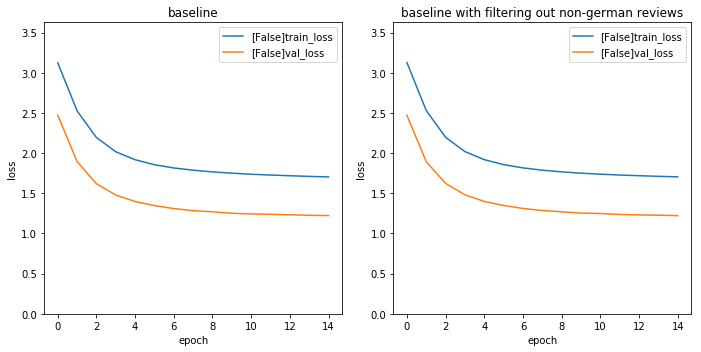

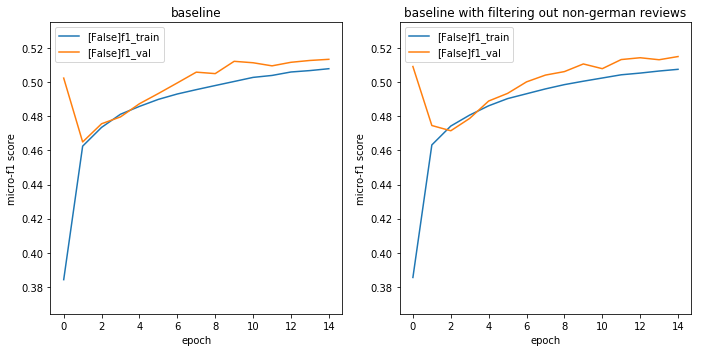

In [3]:
p1 = "blobs/2019-06-21_balanced_100k_usde_baseline/"
p2 = "blobs/2019-06-24_baseline_balanced_100k_filterLang/"
plotExperimentLoss(p1,p2,"baseline", "baseline with filtering out non-german reviews")
plotExperimentf1(p1,p2,"baseline", "baseline with filtering out non-german reviews")

## Include the review headline

Sometimes the author of the review writes something like "A very good Movie" into the headline of the review. I thought this is a useful information since we're doing category prediction here.

However, this also didn't change the performance much.

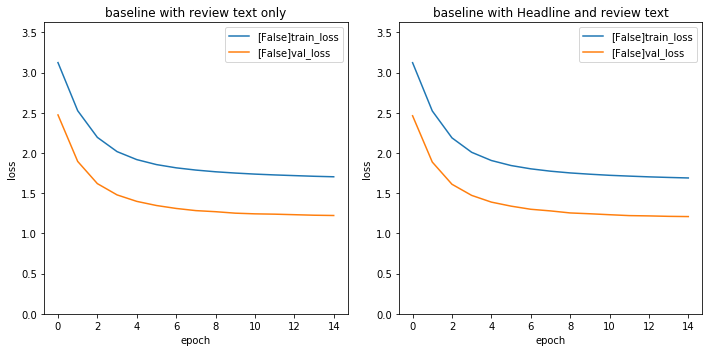

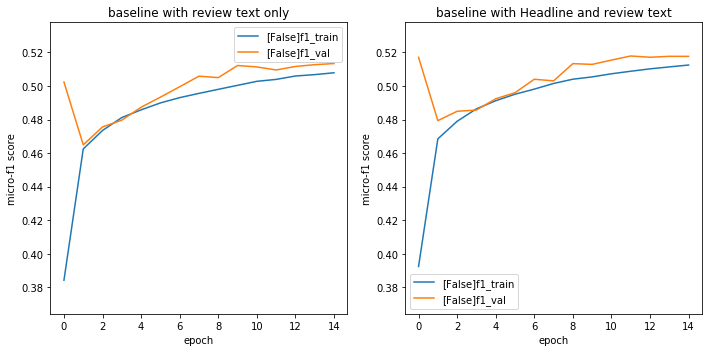

In [0]:
p1 = "blobs/2019-06-21_balanced_100k_usde_baseline/"
p2 = "blobs/2019-06-24_baseline_balanced_100k_withHeader/"
plotExperimentLoss(p1,p2,"baseline with review text only", "baseline with Headline and review text")
plotExperimentf1(p1,p2,"baseline with review text only", "baseline with Headline and review text")

## use larger training set

As described above deeper networks overfit very quickly. In this experiment I trained a model with 4 fully connected layers (followed by relu and dropout after each layer) on a larger training set.

The left column shows the model trained on 300.000 samples. The column show the same model trained on a larger training set with 2 million samples.

*Unexpectedly, increasing the training set size decreased the performance!*

Training time: 3.1 hours
Architecture: [False, 250, 'r', 'd', 150, 'r', 'd', 100, 'r', 'd', 50, 'r', 'd']
Training time: 9.8 hours
Architecture: [False, 250, 'r', 'd', 150, 'r', 'd', 100, 'r', 'd', 50, 'r', 'd']


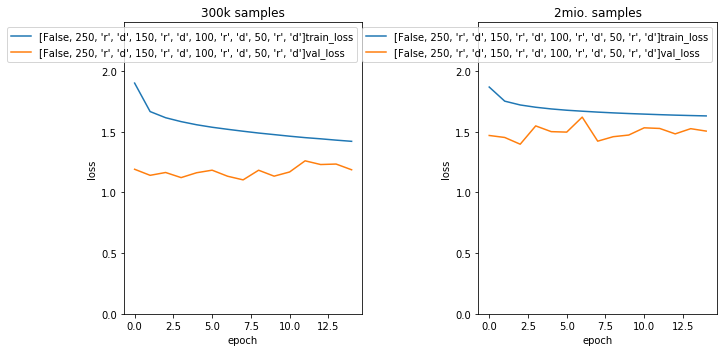

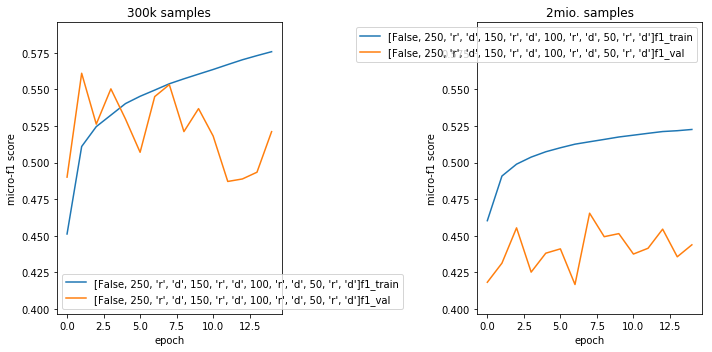

In [0]:
p1 = "blobs/2019-06-24_deep_balanced_300k_dropout/"
p2 = "blobs/2019-07-02_balanced_big50k_deep/"
showExperimentInfo(p1)
showExperimentInfo(p2)
plotExperimentLoss(p1,p2,"300k samples", "2mio. samples")
plotExperimentf1(p1,p2,"300k samples", "2mio. samples")

## different optimizer

So far I used always the ADAM optimizer. Another popular choice is Adadelta.

Surprisingly Adadelta does not work at all.

Training time: 5.8 hours
Architecture: [False, 150, 'r', 'd']


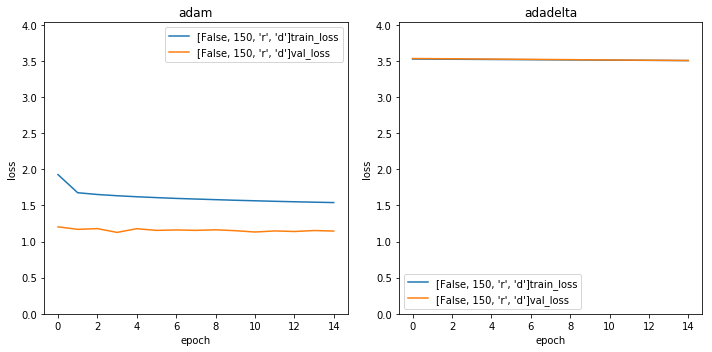

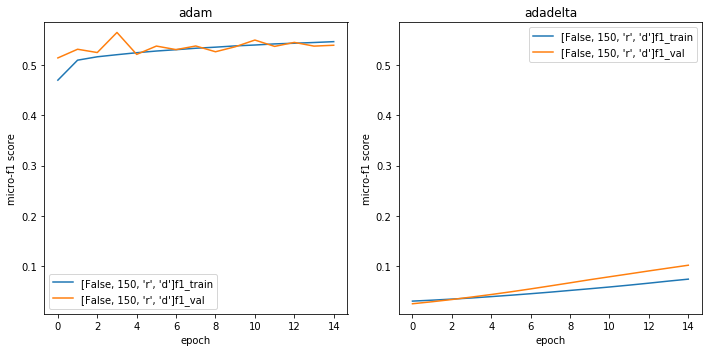

In [0]:
p1 = "blobs/2019-06-25_balanced_full_search2/"
p2 = "blobs/2019-06-25_balanced_full_search2Adadelta/"
title1="adam"
title2="adadelta"
showExperimentInfo(p1)
plotExperimentLoss(p1,p2,title1, title2)
plotExperimentf1(p1,p2,title1, title2)

## detailed training curves for the organic dataset

Here are the training details for training a model from scratch on the organic dataset. I used the baseline model here (only xling+softmax)

### relevance

Training time: 0.1 hours
Architecture: [False]


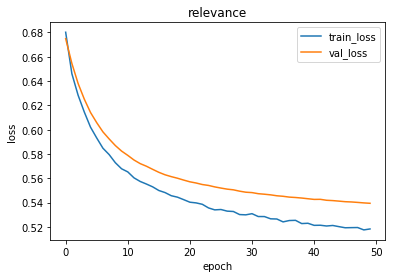

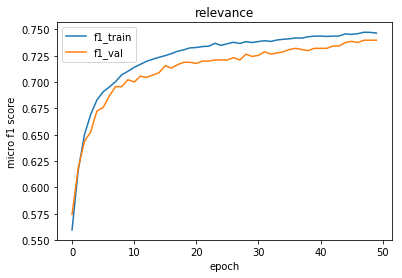

In [0]:
path = "blobs/2019-06-23_organic_baseline_relevance/"
plotLoss(path, title="relevance")
plotF1(path, title="relevance")

### entity

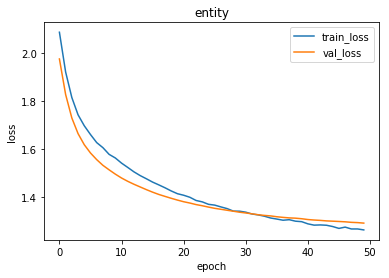

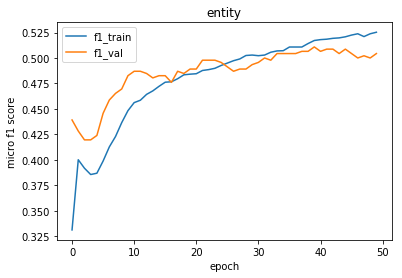

In [0]:
path = "blobs/2019-06-23_organic_baseline_entity/"
plotLoss(path, title="entity")
plotF1(path, title="entity")

### attribute

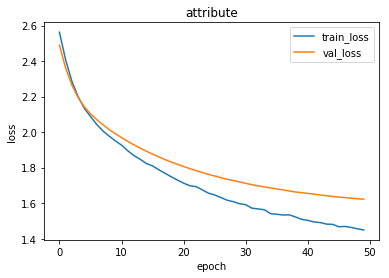

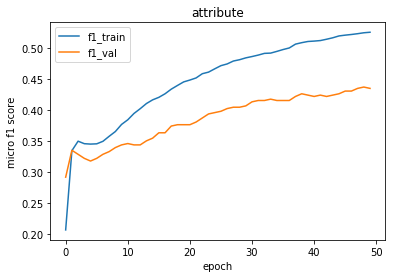

In [0]:
path = "blobs/2019-06-23_organic_baseline_attribute/"
plotLoss(path, title="attribute")
plotF1(path, title="attribute")

## organic multi-label classification
<a id='multilabel'></a>

I did also look briefly into doing multilabel classification on the organic dataset - meaning predicting the attribute, entity and relevance at once in a single model. Due to limited time I couldn't completely finish this task. However here are some insights and results I gained:

*   For multi-class & multi-label the evaluation and measurement of the model performance is not so straightforward. Measuring the accuracy with sklearn computes the subset accuracy. This is a very harsh metric, because it counts only exact matches (across all dimensions).
*   Sklearn does support micro f1 score for multi-class & multi-label problems.
* One interesting metric for multi-label problems is the Hamming score which is the fraction of the correct predicted features to the total number of features

Here are the results I got so far for multi-label classification:

|   Data	|  micro f1 | hamming score
|:---:	|:---:	|:---:	
| organic train	          | 49,27 %       | 32,69%  	  
| organic val              | 49,10 %       | 32,54 % 


![](imgs/organic_multilabel_results.png)


The results do not look very good. Surprisingly, **the harsh (subset) accuracy is at 0% meaning there is not a single example where all features are correctly predicted.**
It may be that there exists an implementation error from my side at the current state. Unfortunately, due to lack of time I couldn't have a closer look into this. 


